In [141]:
# Import related libraries
import numpy as np
import pandas as pd
import torch
from torch import optim
from torch.nn import BatchNorm1d, Dropout, LeakyReLU, Linear, Module, ReLU, Sequential, functional, BCEWithLogitsLoss, MSELoss
from tqdm import tqdm

from ctgan.data_sampler import DataSampler
from ctgan.data_transformer import DataTransformer
from ctgan.errors import InvalidDataError
from ctgan.synthesizers.base import BaseSynthesizer, random_state
from causallearn.search.ConstraintBased.PC import pc
from causallearn.graph.SHD import SHD

from collections import namedtuple, deque

from joblib import Parallel, delayed
from rdt.transformers import ClusterBasedNormalizer, OneHotEncoder
import warnings, copy, math, json

## Data Transformer

In [142]:
SpanInfo = namedtuple('SpanInfo', ['dim', 'activation_fn'])
ColumnTransformInfo = namedtuple(
    'ColumnTransformInfo',
    ['column_name', 'column_type', 'transform', 'output_info', 'output_dimensions'],
)


class DataTransformer(object):
    """Data Transformer.

    Model continuous columns with a BayesianGMM and normalize them to a scalar between [-1, 1]
    and a vector. Discrete columns are encoded using a OneHotEncoder.
    """

    def __init__(self, max_clusters=10, weight_threshold=0.005):
        """Create a data transformer.

        Args:
            max_clusters (int):
                Maximum number of Gaussian distributions in Bayesian GMM.
            weight_threshold (float):
                Weight threshold for a Gaussian distribution to be kept.
        """
        self._max_clusters = max_clusters
        self._weight_threshold = weight_threshold

    def _fit_continuous(self, data):
        """Train Bayesian GMM for continuous columns.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        gm = ClusterBasedNormalizer(
            missing_value_generation='from_column',
            max_clusters=min(len(data), self._max_clusters),
            weight_threshold=self._weight_threshold,
        )
        gm.fit(data, column_name)
        num_components = sum(gm.valid_component_indicator)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='continuous',
            transform=gm,
            output_info=[SpanInfo(1, 'tanh'), SpanInfo(num_components, 'softmax')],
            output_dimensions=1 + num_components,
        )

    def _fit_discrete(self, data):
        """Fit one hot encoder for discrete column.

        Args:
            data (pd.DataFrame):
                A dataframe containing a column.

        Returns:
            namedtuple:
                A ``ColumnTransformInfo`` object.
        """
        column_name = data.columns[0]
        ohe = OneHotEncoder()
        ohe.fit(data, column_name)
        num_categories = len(ohe.dummies)

        return ColumnTransformInfo(
            column_name=column_name,
            column_type='discrete',
            transform=ohe,
            output_info=[SpanInfo(num_categories, 'softmax')],
            output_dimensions=num_categories,
        )

    def fit(self, raw_data, discrete_columns=()):
        """Fit the ``DataTransformer``.

        Fits a ``ClusterBasedNormalizer`` for continuous columns and a
        ``OneHotEncoder`` for discrete columns.

        This step also counts the #columns in matrix data and span information.
        """
        self.output_info_list = []
        self.output_dimensions = 0
        self.dataframe = True

        if not isinstance(raw_data, pd.DataFrame):
            self.dataframe = False
            # work around for RDT issue #328 Fitting with numerical column names fails
            discrete_columns = [str(column) for column in discrete_columns]
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        self._column_raw_dtypes = raw_data.infer_objects().dtypes
        self._column_transform_info_list = []
        for column_name in raw_data.columns:
            if column_name in discrete_columns:
                column_transform_info = self._fit_discrete(raw_data[[column_name]])
            else:
                column_transform_info = self._fit_continuous(raw_data[[column_name]])

            self.output_info_list.append(column_transform_info.output_info)
            self.output_dimensions += column_transform_info.output_dimensions
            self._column_transform_info_list.append(column_transform_info)

    def _transform_continuous(self, column_transform_info, data):
        column_name = data.columns[0]
        flattened_column = data[column_name].to_numpy().flatten()
        data = data.assign(**{column_name: flattened_column})
        gm = column_transform_info.transform
        transformed = gm.transform(data)

        #  Converts the transformed data to the appropriate output format.
        #  The first column (ending in '.normalized') stays the same,
        #  but the lable encoded column (ending in '.component') is one hot encoded.
        output = np.zeros((len(transformed), column_transform_info.output_dimensions))
        output[:, 0] = transformed[f'{column_name}.normalized'].to_numpy()
        index = transformed[f'{column_name}.component'].to_numpy().astype(int)
        output[np.arange(index.size), index + 1] = 1.0

        return output

    def _transform_discrete(self, column_transform_info, data):
        ohe = column_transform_info.transform
        return ohe.transform(data).to_numpy()

    def _synchronous_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns synchronous.

        Outputs a list with Numpy arrays.
        """
        column_data_list = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            if column_transform_info.column_type == 'continuous':
                column_data_list.append(self._transform_continuous(column_transform_info, data))
            else:
                column_data_list.append(self._transform_discrete(column_transform_info, data))

        return column_data_list

    def _parallel_transform(self, raw_data, column_transform_info_list):
        """Take a Pandas DataFrame and transform columns in parallel.

        Outputs a list with Numpy arrays.
        """
        processes = []
        for column_transform_info in column_transform_info_list:
            column_name = column_transform_info.column_name
            data = raw_data[[column_name]]
            process = None
            if column_transform_info.column_type == 'continuous':
                process = delayed(self._transform_continuous)(column_transform_info, data)
            else:
                process = delayed(self._transform_discrete)(column_transform_info, data)
            processes.append(process)

        return Parallel(n_jobs=-1)(processes)

    def transform(self, raw_data):
        """Take raw data and output a matrix data."""
        if not isinstance(raw_data, pd.DataFrame):
            column_names = [str(num) for num in range(raw_data.shape[1])]
            raw_data = pd.DataFrame(raw_data, columns=column_names)

        # Only use parallelization with larger data sizes.
        # Otherwise, the transformation will be slower.
        if raw_data.shape[0] < 500:
            column_data_list = self._synchronous_transform(
                raw_data, self._column_transform_info_list
            )
        else:
            column_data_list = self._parallel_transform(raw_data, self._column_transform_info_list)

        return np.concatenate(column_data_list, axis=1).astype(float)

    def _inverse_transform_continuous(self, column_transform_info, column_data, sigmas, st):
        gm = column_transform_info.transform
        data = pd.DataFrame(column_data[:, :2], columns=list(gm.get_output_sdtypes())).astype(float)
        data[data.columns[1]] = np.argmax(column_data[:, 1:], axis=1)
        if sigmas is not None:
            selected_normalized_value = np.random.normal(data.iloc[:, 0], sigmas[st])
            data.iloc[:, 0] = selected_normalized_value

        return gm.reverse_transform(data)

    def _inverse_transform_discrete(self, column_transform_info, column_data):
        ohe = column_transform_info.transform
        data = pd.DataFrame(column_data, columns=list(ohe.get_output_sdtypes()))
        return ohe.reverse_transform(data)[column_transform_info.column_name]

    def inverse_transform(self, data, sigmas=None):
        """Take matrix data and output raw data.

        Output uses the same type as input to the transform function.
        Either np array or pd dataframe.
        """
        st = 0
        recovered_column_data_list = []
        column_names = []
        for column_transform_info in self._column_transform_info_list:
            dim = column_transform_info.output_dimensions
            column_data = data[:, st : st + dim]
            if column_transform_info.column_type == 'continuous':
                recovered_column_data = self._inverse_transform_continuous(
                    column_transform_info, column_data, sigmas, st
                )
            else:
                recovered_column_data = self._inverse_transform_discrete(
                    column_transform_info, column_data
                )

            recovered_column_data_list.append(recovered_column_data)
            column_names.append(column_transform_info.column_name)
            st += dim

        recovered_data = np.column_stack(recovered_column_data_list)
        recovered_data = pd.DataFrame(recovered_data, columns=column_names).astype(
            self._column_raw_dtypes
        )
        if not self.dataframe:
            recovered_data = recovered_data.to_numpy()

        return recovered_data

    def convert_column_name_value_to_id(self, column_name, value):
        """Get the ids of the given `column_name`."""
        discrete_counter = 0
        column_id = 0
        for column_transform_info in self._column_transform_info_list:
            if column_transform_info.column_name == column_name:
                break
            if column_transform_info.column_type == 'discrete':
                discrete_counter += 1

            column_id += 1

        else:
            raise ValueError(f"The column_name `{column_name}` doesn't exist in the data.")

        ohe = column_transform_info.transform
        data = pd.DataFrame([value], columns=[column_transform_info.column_name])
        one_hot = ohe.transform(data).to_numpy()[0]
        if sum(one_hot) == 0:
            raise ValueError(f"The value `{value}` doesn't exist in the column `{column_name}`.")

        return {
            'discrete_column_id': discrete_counter,
            'column_id': column_id,
            'value_id': np.argmax(one_hot),
        }

## Data Sampler

In [143]:
class DataSampler(object):
    """DataSampler samples the conditional vector and corresponding data for CTGAN."""

    def __init__(self, data, output_info, log_frequency):
        self._data_length = len(data)

        def is_discrete_column(column_info):
            return len(column_info) == 1 and column_info[0].activation_fn == 'softmax'

        n_discrete_columns = sum([
            1 for column_info in output_info if is_discrete_column(column_info)
        ])

        self._discrete_column_matrix_st = np.zeros(n_discrete_columns, dtype='int32')

        # Store the row id for each category in each discrete column.
        # For example _rid_by_cat_cols[a][b] is a list of all rows with the
        # a-th discrete column equal value b.
        self._rid_by_cat_cols = []

        # Compute _rid_by_cat_cols
        st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim

                rid_by_cat = []
                for j in range(span_info.dim):
                    rid_by_cat.append(np.nonzero(data[:, st + j])[0])
                self._rid_by_cat_cols.append(rid_by_cat)
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])
        assert st == data.shape[1]

        # Prepare an interval matrix for efficiently sample conditional vector
        max_category = max(
            [column_info[0].dim for column_info in output_info if is_discrete_column(column_info)],
            default=0,
        )

        self._discrete_column_cond_st = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_n_category = np.zeros(n_discrete_columns, dtype='int32')
        self._discrete_column_category_prob = np.zeros((n_discrete_columns, max_category))
        self._n_discrete_columns = n_discrete_columns
        self._n_categories = sum([
            column_info[0].dim for column_info in output_info if is_discrete_column(column_info)
        ])

        st = 0
        current_id = 0
        current_cond_st = 0
        for column_info in output_info:
            if is_discrete_column(column_info):
                span_info = column_info[0]
                ed = st + span_info.dim
                category_freq = np.sum(data[:, st:ed], axis=0)
                if log_frequency:
                    category_freq = np.log(category_freq + 1)
                category_prob = category_freq / np.sum(category_freq)
                self._discrete_column_category_prob[current_id, : span_info.dim] = category_prob
                self._discrete_column_cond_st[current_id] = current_cond_st
                self._discrete_column_n_category[current_id] = span_info.dim
                current_cond_st += span_info.dim
                current_id += 1
                st = ed
            else:
                st += sum([span_info.dim for span_info in column_info])

    def _random_choice_prob_index(self, discrete_column_id):
        probs = self._discrete_column_category_prob[discrete_column_id]
        r = np.expand_dims(np.random.rand(probs.shape[0]), axis=1)
        return (probs.cumsum(axis=1) > r).argmax(axis=1)

    def sample_condvec(self, batch):
        """Generate the conditional vector for training.

        Returns:
            cond (batch x #categories):
                The conditional vector.
            mask (batch x #discrete columns):
                A one-hot vector indicating the selected discrete column.
            discrete column id (batch):
                Integer representation of mask.
            category_id_in_col (batch):
                Selected category in the selected discrete column.
        """
        if self._n_discrete_columns == 0:
            return None

        discrete_column_id = np.random.choice(np.arange(self._n_discrete_columns), batch)

        cond = np.zeros((batch, self._n_categories), dtype='float32')
        mask = np.zeros((batch, self._n_discrete_columns), dtype='float32')
        mask[np.arange(batch), discrete_column_id] = 1
        category_id_in_col = self._random_choice_prob_index(discrete_column_id)
        category_id = self._discrete_column_cond_st[discrete_column_id] + category_id_in_col
        cond[np.arange(batch), category_id] = 1

        return cond, mask, discrete_column_id, category_id_in_col

    def sample_original_condvec(self, batch):
        """Generate the conditional vector for generation use original frequency."""
        if self._n_discrete_columns == 0:
            return None

        category_freq = self._discrete_column_category_prob.flatten()
        category_freq = category_freq[category_freq != 0]
        category_freq = category_freq / np.sum(category_freq)
        col_idxs = np.random.choice(np.arange(len(category_freq)), batch, p=category_freq)
        cond = np.zeros((batch, self._n_categories), dtype='float32')
        cond[np.arange(batch), col_idxs] = 1

        return cond

    def sample_data(self, data, n, col, opt):
        """Sample data from original training data satisfying the sampled conditional vector.

        Args:
            data:
                The training data.

        Returns:
            n:
                n rows of matrix data.
        """
        if col is None:
            idx = np.random.randint(len(data), size=n)
            return data[idx]

        idx = []
        for c, o in zip(col, opt):
            idx.append(np.random.choice(self._rid_by_cat_cols[c][o]))

        return data[idx]

    def dim_cond_vec(self):
        """Return the total number of categories."""
        return self._n_categories

    def generate_cond_from_condition_column_info(self, condition_info, batch):
        """Generate the condition vector."""
        vec = np.zeros((batch, self._n_categories), dtype='float32')
        id_ = self._discrete_column_matrix_st[condition_info['discrete_column_id']]
        id_ += condition_info['value_id']
        vec[:, id_] = 1
        return vec

## Model Class

In [144]:
class Discriminator(Module):
    """Discriminator for the CTGAN."""

    def __init__(self, input_dim, discriminator_dim, pac=10):
        super(Discriminator, self).__init__()
        dim = input_dim * pac
        self.pac = pac
        self.pacdim = dim
        seq = []
        for item in list(discriminator_dim):
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(0.5)]
            dim = item

        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def calc_gradient_penalty(self, real_data, fake_data, device='cpu', pac=10, lambda_=10):
        """Compute the gradient penalty."""
        alpha = torch.rand(real_data.size(0) // pac, 1, 1, device=device)
        alpha = alpha.repeat(1, pac, real_data.size(1))
        alpha = alpha.view(-1, real_data.size(1))

        interpolates = alpha * real_data + ((1 - alpha) * fake_data)

        disc_interpolates = self(interpolates)

        gradients = torch.autograd.grad(
            outputs=disc_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(disc_interpolates.size(), device=device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        gradients_view = gradients.view(-1, pac * real_data.size(1)).norm(2, dim=1) - 1
        gradient_penalty = ((gradients_view) ** 2).mean() * lambda_

        return gradient_penalty

    def forward(self, input_):
        """Apply the Discriminator to the `input_`."""
        assert input_.size()[0] % self.pac == 0
        return self.seq(input_.view(-1, self.pacdim))

In [145]:
class Residual(Module):
    """Residual layer for the CTGAN."""

    def __init__(self, i, o):
        super(Residual, self).__init__()
        self.fc = Linear(i, o)
        self.bn = BatchNorm1d(o)
        self.relu = ReLU()

    def forward(self, input_):
        """Apply the Residual layer to the `input_`."""
        out = self.fc(input_)
        out = self.bn(out)
        out = self.relu(out)
        return torch.cat([out, input_], dim=1)

In [146]:
class Generator(Module):
    """Generator for the CTGAN."""

    def __init__(self, embedding_dim, generator_dim, data_dim):
        super(Generator, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(generator_dim):
            seq += [Residual(dim, item)]
            dim += item
        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)

    def forward(self, input_):
        """Apply the Generator to the `input_`."""
        data = self.seq(input_)
        return data

In [147]:
class RewardCritic(Module):
    """
    Surrogate reward network: x (fake_act [+ cond]) -> r_hat in (0,1),
    xấp xỉ R_true = exp(-alpha_shd * SHD).
    Kiến trúc MLP giống phong cách Discriminator (LeakyReLU + Dropout).
    """
    def __init__(self, input_dim, critic_dim, p_drop=0.5):
        super().__init__()
        seq = []
        dim = input_dim
        for item in critic_dim:
            seq += [Linear(dim, item), LeakyReLU(0.2), Dropout(p_drop)]
            dim = item
        seq += [Linear(dim, 1)]
        self.seq = Sequential(*seq)

    def forward(self, x):  # x: (B, input_dim)
        return self.seq(x).squeeze(-1)  # (B,)

## CTGAN Related Function

In [148]:
transformer = DataTransformer()

In [149]:
def gumbel_softmax(logits, tau=1, hard=False, eps=1e-10, dim=-1):
    """Deals with the instability of the gumbel_softmax for older versions of torch.

        For more details about the issue:
        https://drive.google.com/file/d/1AA5wPfZ1kquaRtVruCd6BiYZGcDeNxyP/view?usp=sharing

        Args:
            logits […, num_features]:
                Unnormalized log probabilities
            tau:
                Non-negative scalar temperature
            hard (bool):
                If True, the returned samples will be discretized as one-hot vectors,
                but will be differentiated as if it is the soft sample in autograd
            dim (int):
                A dimension along which softmax will be computed. Default: -1.

        Returns:
            Sampled tensor of same shape as logits from the Gumbel-Softmax distribution.
     """
    for _ in range(10):
        transformed = functional.gumbel_softmax(logits, tau=tau, hard=hard, eps=eps, dim=dim)
        if not torch.isnan(transformed).any():
            return transformed

    raise ValueError('gumbel_softmax returning NaN.')

def apply_activate(output_info_list, data):
    """Apply proper activation function to the output of the generator."""
    data_t = []
    st = 0
    for column_info in output_info_list:
        for span_info in column_info:
            if span_info.activation_fn == 'tanh':
                ed = st + span_info.dim
                data_t.append(torch.tanh(data[:, st:ed]))
                st = ed
            elif span_info.activation_fn == 'softmax':
                ed = st + span_info.dim
                transformed = gumbel_softmax(data[:, st:ed], tau=0.2)
                data_t.append(transformed)
                st = ed
            else:
                raise ValueError(f'Unexpected activation function {span_info.activation_fn}.')

    return torch.cat(data_t, dim=1)

def cond_loss(output_info_list, data, c, m):
    """Compute the cross entropy loss on the fixed discrete column."""
    loss = []
    st = 0
    st_c = 0
    for column_info in output_info_list:
        for span_info in column_info:
            if len(column_info) != 1 or span_info.activation_fn != 'softmax':
                # not discrete column
                st += span_info.dim
            else:
                ed = st + span_info.dim
                ed_c = st_c + span_info.dim
                tmp = functional.cross_entropy(
                    data[:, st:ed], torch.argmax(c[:, st_c:ed_c], dim=1), reduction='none'
                )
                loss.append(tmp)
                st = ed
                st_c = ed_c

    loss = torch.stack(loss, dim=1)  # noqa: PD013

    return (loss * m).sum() / data.size()[0]

def validate_null_data(train_data, discrete_columns):
    """Check whether null values exist in continuous ``train_data``.

        Args:
            train_data (numpy.ndarray or pandas.DataFrame):
                Training Data. It must be a 2-dimensional numpy array or a pandas.DataFrame.
            discrete_columns (list-like):
                List of discrete columns to be used to generate the Conditional
                Vector. If ``train_data`` is a Numpy array, this list should
                contain the integer indices of the columns. Otherwise, if it is
                a ``pandas.DataFrame``, this list should contain the column names.
    """
    if isinstance(train_data, pd.DataFrame):
        continuous_cols = list(set(train_data.columns) - set(discrete_columns))
        any_nulls = train_data[continuous_cols].isna().any().any()
    else:
        continuous_cols = [i for i in range(train_data.shape[1]) if i not in discrete_columns]
        any_nulls = pd.DataFrame(train_data)[continuous_cols].isna().any().any()

    if any_nulls:
        raise InvalidDataError(
            'CTGAN does not support null values in the continuous training data. '
            'Please remove all null values from your continuous training data.'
        )

def sample(transformer, data_sampler, batch_size, generator, embedding_dim, 
           device, output_info_list, n, condition_column=None, condition_value=None):
    if condition_column is not None and condition_value is not None:
        condition_info = transformer.convert_column_name_value_to_id(
            condition_column, condition_value
        )
        global_condition_vec = data_sampler.generate_cond_from_condition_column_info(
            condition_info, batch_size
        )
    else:
        global_condition_vec = None

    steps = n // batch_size + 1
    data = []
    for i in range(steps):
        mean = torch.zeros(batch_size, embedding_dim)
        std = mean + 1
        fakez = torch.normal(mean=mean, std=std).to(device)

        if global_condition_vec is not None:
            condvec = global_condition_vec.copy()
        else:
            condvec = data_sampler.sample_original_condvec(batch_size)

        if condvec is None:
            pass
        else:
            c1 = condvec
            c1 = torch.from_numpy(c1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

        fake = generator(fakez)
        fakeact = apply_activate(output_info_list, fake)
        data.append(fakeact.detach().cpu().numpy())

    data = np.concatenate(data, axis=0)
    data = data[:n]

    return transformer.inverse_transform(data)

def set_device(device, generator):
    """Set the `device` to be used ('GPU' or 'CPU)."""
    device = device
    if generator is not None:
        generator.to(device)
            
#def batch_features(x: torch.Tensor) -> torch.Tensor:
    """Batch-level features [mean, var]; keeps grad to x."""
#    mu  = x.mean(dim=0)                        # (D',)
#    var = x.var(dim=0, unbiased=False)         # (D',)
#    return torch.cat([mu, var], dim=0)         # (2D',)

'''def batch_features(x, unbiased=False, flatten=True):
    """
    Tính batch-level mean và covariance cho tensor x có shape (B, D).
    - unbiased=False  => chia cho N (giống var(..., unbiased=False))
      unbiased=True   => chia cho N-1
    - flatten=True    => trả về 1 tensor: [mu, vec(cov)]
      flatten=False   => trả về tuple (mu, cov)

    Trả về:
      - nếu flatten=False: (mu: (D,), cov: (D,D))
      - nếu flatten=True : (D + D*D,)
    """
    # mean (D,)
    mu = x.mean(dim=0)

    # center
    xc = x - mu.unsqueeze(0)

    # mẫu số
    n = x.shape[0]
    denom = (n - 1) if (unbiased and n > 1) else n
    denom = max(denom, 1)  # tránh chia 0 khi n==1

    # covariance (D,D), giữ grad
    cov = (xc.T @ xc) / denom

    if flatten:
        return torch.cat([mu, cov.reshape(-1)], dim=0)
    return mu, cov
'''
def batch_features(x: torch.Tensor, topk: int = 3, eps: float = 1e-6) -> torch.Tensor:
    """
    Batch-level features with fixed size 2D':
      - First D': per-feature mean.
      - Second D': fused "dispersion + dependency" per feature:
          fuse = 0.5 * variance + 0.5 * top-k mean(|corr|) per column.
    Keeps grad to x.
    """
    # x: (B, D')
    B, D = x.shape

    # 1) per-feature mean / var
    mu  = x.mean(dim=0)                                # (D,)
    var = x.var(dim=0, unbiased=False)                 # (D,)

    # 2) per-feature dependency via correlation with others
    # standardize columns (keep grad)
    x_center = x - mu.unsqueeze(0)                     # (B, D)
    std = x_center.std(dim=0, unbiased=False) + eps
    x_norm = x_center / std                            # (B, D)

    # correlation matrix (D, D)
    corr = (x_norm.T @ x_norm) / max(1, B - 1)
    corr_abs = corr.abs()

    # zero out diagonal, then take per-column top-k mean |corr|
    corr_abs = corr_abs - torch.diag_embed(torch.diag(corr_abs))
    k = min(topk, max(1, D - 1))
    # top-k along columns (dim=0) for each row/feature
    topk_vals, _ = torch.topk(corr_abs, k=k, dim=1)
    dep_col = topk_vals.mean(dim=1)                    # (D,)

    # 3) fuse dispersion + dependency to keep output length = 2D
    # (optionally normalize scales if needed)
    fused = 0.5 * var + 0.5 * dep_col                  # (D,)

    # 4) final feature vector
    feat = torch.cat([mu, fused], dim=0)               # (2D,)
    return feat


def pc_graph(df: pd.DataFrame, train_data=None, discrete_columns=()):
    # Chọn ci_test phù hợp nếu dữ liệu nhiều rời rạc
    if isinstance(train_data, pd.DataFrame):
        ori_data_df = train_data.copy()
        n_cols = ori_data_df.shape[1]
        disc_ratio = (len(discrete_columns) / max(1, n_cols)) if n_cols else 0.0
    else:
        ori_data_df = pd.DataFrame(train_data)
        n_cols = ori_data_df.shape[1]
        disc_ratio = 0.0
    ci_kw = {}
    if disc_ratio >= 0.5:                # dữ liệu rời rạc nhiều -> gsq ổn hơn fisherz
        ci_kw = {'ci_test': 'gsq'}
    try:
        return pc(df.to_numpy(), alpha=0.05, **ci_kw)
    except TypeError:
        # phiên bản causallearn cũ không có ci_test arg
        return pc(df.to_numpy(), alpha=0.05)

def shd_against_real(gen_df: pd.DataFrame, cg_org):
    cg_gen = pc_graph(gen_df)
    adj_org = copy.deepcopy(cg_org.G.graph); adj_org[adj_org == -1] = 0
    adj_gen = copy.deepcopy(cg_gen.G.graph); adj_gen[adj_gen == -1] = 0
    adj_org = np.transpose(adj_org); adj_gen = np.transpose(adj_gen)
    graph_org = copy.deepcopy(cg_org.G); graph_gen = copy.deepcopy(cg_gen.G)
    graph_org.graph = adj_org;        graph_gen.graph = adj_gen
    return float(SHD(graph_org, graph_gen).get_shd())

def read_csv(csv_filename, meta_filename=None, header=True, discrete=None):
    """Read a csv file."""
    data = pd.read_csv(csv_filename, header='infer' if header else None)

    if meta_filename:
        with open(meta_filename) as meta_file:
            metadata = json.load(meta_file)

        discrete_columns = [
            column['name'] for column in metadata['columns'] if column['type'] != 'continuous'
        ]

    elif discrete:
        discrete_columns = discrete.split(',')
        if not header:
            discrete_columns = [int(i) for i in discrete_columns]

    else:
        discrete_columns = []

    return data, discrete_columns

## Set Up Params

In [ ]:
embedding_dim=128
generator_dim=(256, 256)
discriminator_dim=(256, 256)
critic_dim=(256, 256)
generator_lr=2e-4
generator_decay=1e-6
discriminator_lr=2e-4
discriminator_decay=1e-6
critic_lr=4e-4
critic_decay=2e-6
batch_size=400
discriminator_steps=1
log_frequency=True
verbose=False
epochs=400
pac=10
cuda=True

if not cuda or not torch.cuda.is_available():
    device = 'cpu'
elif isinstance(cuda, str):
    device = cuda
else:
    device = 'cuda'

device = torch.device(device)

# logs & reward configs
loss_values = pd.DataFrame(columns=['Epoch', 'Generator Loss', 'Discriminator Loss', 'Critic Loss'])
last_lossR = 0.0

# ---------- schedules & gates ----------
pretrain_gd_epochs = 200   # only D/G
pretrain_r_epochs  = 50 # only Critic
t0 = pretrain_gd_epochs + pretrain_r_epochs


# shaping config
lambda_max = 0.0001            # rất bảo thủ; tăng nếu đã ổn
ready_thresh = 0.25            # Critic BCE < ngưỡng mới cho shaping
k_step_R = 4                  # train Critic thưa
ratio_cap = 0.20               # reward ≤ 20% |adv_loss|
corr_min = 0.25                # yêu cầu tương quan dương tối thiểu
corr_buf = deque(maxlen=60)    # lưu (R_true, r_hat) để đánh giá
shd_hist = deque(maxlen=50)    # cho alpha động
best_shd = float('inf')
no_improve_epochs = 0
patience_stop = 20             # nếu không cải thiện SHD N epoch -> tắt shaping hoàn toàn
shaping_forced_off = False

train_data, discrete_columns = read_csv("original_data.csv", None, True, None)
print(f'Loaded data with {len(train_data)} rows and {len(train_data.columns)} columns.')
cg_org = pc_graph(train_data)

Loaded data with 10000 rows and 6 columns.


Depth=3, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 3159.55it/s]


In [151]:
transformer = DataTransformer()
transformer.fit(train_data, discrete_columns)
train_data = transformer.transform(train_data)

In [152]:
data_sampler = DataSampler(
        train_data, transformer.output_info_list, log_frequency
    )
data_dim = transformer.output_dimensions

In [153]:
# ---------- build models ----------
generator = Generator(
    embedding_dim + data_sampler.dim_cond_vec(),
    generator_dim,
    data_dim
    ).to(device)

discriminator = Discriminator(
    data_dim + data_sampler.dim_cond_vec(),
    discriminator_dim,
    pac=pac
).to(device)

# Critic: batch-level features = [mean, var] -> 1 logit
cond_dim = data_sampler.dim_cond_vec()
critic_in_dim = data_dim + cond_dim         # D'
#feat_dim = critic_in_dim * critic_in_dim   + critic_in_dim             # [mean, var]
feat_dim = critic_in_dim  + critic_in_dim             # [mean, var]
reward_critic = RewardCritic(
                feat_dim, critic_dim, p_drop=0.1  # p_drop=0 để ổn định khi dùng cho G
                ).to(device)

# ---------- optimizers ----------
optimizerG = optim.Adam(
            generator.parameters(),
            lr=generator_lr, betas=(0.5, 0.9),
            weight_decay=generator_decay,
        )
optimizerD = optim.Adam(
            discriminator.parameters(),
            lr=discriminator_lr, betas=(0.5, 0.9),
            weight_decay=discriminator_decay,
        )
optimizerR = optim.Adam(
            reward_critic.parameters(),
            lr=critic_lr, betas=(0.5, 0.9),
            weight_decay=critic_decay,
        )

# ---------- helpers ----------
mean = torch.zeros(batch_size, embedding_dim, device=device)
std = mean + 1
bce = BCEWithLogitsLoss() 
mse = MSELoss()

In [154]:
epoch_iterator = tqdm(range(epochs), disable=(not verbose))
if verbose:
    desc = 'Gen. ({gen:.4f}) | Discrim. ({dis:.4f}) | Critic ({cri:.4f})'
    epoch_iterator.set_description(desc.format(gen=0, dis=0, cri=0))

steps_per_epoch = max(len(train_data) // batch_size, 1)
global_step = 0
loss_g = torch.tensor(0.0, device=device)
loss_d = torch.tensor(0.0, device=device)

In [155]:
# --- Hyper cho monitor ---
ROLL = 100        # cửa sổ trượt theo step
MARGIN_HI = 0.8   # D quá mạnh
MARGIN_LO = 0.1   # D quá yếu
GRAD_G_MIN = 1e-6 # vanishing grad G
CORR_MIN_MON = 0.3

# --- Bộ đệm quan sát theo "step" ---
buf_yreal = deque(maxlen=ROLL)
buf_yfake = deque(maxlen=ROLL)
buf_gp    = deque(maxlen=ROLL)
buf_gnorm = deque(maxlen=ROLL)
buf_dnorm = deque(maxlen=ROLL)
buf_glr   = deque(maxlen=ROLL)   # norm update G (ước lượng)
buf_dlr   = deque(maxlen=ROLL)   # norm update D (ước lượng)
buf_adv   = deque(maxlen=ROLL)
buf_lam   = deque(maxlen=ROLL)

# VarRatio cho 1 vài cột numeric tiêu biểu
buf_var_numeric = {}  # {col_idx: deque([...], maxlen=ROLL)}

# --- Lịch sử theo "epoch" để vẽ ---
hist_epoch = []  # list các epoch index
yreal_epoch_mean, yfake_epoch_mean = [], []
west_epoch, gp_epoch_mean = [], []
gnorm_epoch_mean, dnorm_epoch_mean = [], []
glr_epoch_mean,  dlr_epoch_mean  = [], []
adv_epoch_mean,  gtot_epoch = [], []
lam_epoch_mean = []
corr_epoch = []
shd_epoch  = []
varratio_epoch_by_col = {}  # {k: [v1, v2, ...] theo epoch}

def param_update_norm(opt):
    """
    Ước lượng độ lớn cập nhật tham số: sqrt(sum (lr * ||grad||)^2).
    Tính theo từng param_group để đảm bảo LR đúng với tham số tương ứng.
    """
    s = 0.0
    c = 0
    for pg in opt.param_groups:
        lr = pg['lr']
        for p in pg['params']:
            if p.grad is not None:
                s += (lr * p.grad.detach().norm().item())**2
                c += 1
    return (s**0.5) if c > 0 else 0.0

def grad_norm(model):
    """sqrt(sum ||grad||^2) cho tất cả tham số có grad."""
    s = 0.0
    c = 0
    for p in model.parameters():
        if p.grad is not None:
            s += p.grad.detach().norm().item()**2
            c += 1
    return (s**0.5) if c > 0 else 0.0

def quick_var_check(real_batch_np, fake_batch_t, numeric_idxs=(0,1,2)):
    """
    So sánh phương sai fake/real cho vài cột numeric (để bắt mode collapse sớm).
    Gọi hàm này khi bạn có real (numpy) và fakeact (torch) cùng shape batch x dim.
    """
    real_var = real_batch_np.var(axis=0)
    fake_var = fake_batch_t.detach().cpu().numpy().var(axis=0)
    for idx in numeric_idxs:
        buf_var_numeric.setdefault(idx, deque(maxlen=ROLL)).append(
            float(fake_var[idx] / (real_var[idx] + 1e-8))
        )

def slope_last(xs, ys, win=20):
    """Độ dốc OLS đơn giản cho 20 điểm gần nhất (ước lượng tốc độ hội tụ)."""
    xs = np.array(xs[-win:], dtype=float)
    ys = np.array(ys[-win:], dtype=float)
    if len(xs) < 3:
        return np.nan
    x = xs - xs.mean()
    y = ys - ys.mean()
    denom = (x**2).sum() + 1e-8
    return float((x*y).sum() / denom)

def rolling_mean(deq):
    return float(np.mean(deq)) if len(deq) else np.nan


In [156]:
import os
import math, torch, torch.nn.functional as F
os.environ["TQDM_DISABLE"] = "1"

In [157]:
n_cols = 6
r_check = []
rhat_hist = deque(maxlen=5)  # lưu 10 r̂ gần nhất (đã sigmoid)
flip_tol = 0.0  # hysteresis; có thể đặt 0.01~0.05 để bớt flip liên tục 
lossG = []

# Controller state (created once)
ctrl = {
    'r_base': None,                 # EMA baseline of r_hat (torch scalar)
    'r_var':  None,                 # EMA variance (torch scalar)
    'lam_prev': None,               # previous λ (torch scalar)
    'cooldown': 0,                  # cooldown counter (int)
    'shd_prev': 0.0                 # previous SHD-EMA (float)
}
output_info_list = transformer.output_info_list
for i in epoch_iterator:
    # ---- Stage switch ----
    if i < pretrain_gd_epochs:
        stage = "gd"   # train D & G
    elif i < t0:
        stage = "r"    # train Critic only
    else:
        stage = "all"  # train D, G, Critic

    for _ in range(steps_per_epoch):

        # =========================
        # 1) D steps (skip if stage == 'r')
        # =========================
        if stage != "r":
            for _d in range(discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)
                    condvec =  data_sampler.sample_condvec( batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real =  data_sampler.sample_data(train_data,  batch_size, col, opt)
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to( device)
                        m1 = torch.from_numpy(m1).to( device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange( batch_size)
                        np.random.shuffle(perm)
                        real =  data_sampler.sample_data(
                            train_data,  batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake =  generator(fakez)
                    fakeact =  apply_activate(output_info_list, fake)

                    real = torch.from_numpy(real.astype('float32')).to( device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        fake_cat = fakeact
                        real_cat = real

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat,  device, pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))
                    loss_d_total = loss_d + pen
                        
                    # --- MONITOR: D-step (trước optimizerD.step) ---
                    with torch.no_grad():
                        buf_yreal.append(y_real.mean().item())
                        buf_yfake.append(y_fake.mean().item())
                        # pen có thể là tensor/float
                        pen_val = pen.item() if hasattr(pen, 'item') else float(pen)
                        buf_gp.append(pen_val)

                    optimizerD.zero_grad(set_to_none=False)
                    # Sau optimizerD.step():
                    with torch.no_grad():
                        buf_dnorm.append(grad_norm(discriminator))
                        buf_dlr.append(param_update_norm(optimizerD))
                    loss_d_total.backward()
                    optimizerD.step()

                # --- MONITOR: sau step mới đo update-norm ---
                    with torch.no_grad():
                        buf_dlr.append(param_update_norm(optimizerD))

        # =========================
        # 2) G forward (chuẩn bị critic_input)
        # =========================
        fakez = torch.normal(mean=mean, std=std)
        condvec = data_sampler.sample_condvec(batch_size)
        if condvec is None:
            c1, m1, col, opt = None, None, None, None
        else:
            c1, m1, col, opt = condvec
            c1 = torch.from_numpy(c1).to(device)
            m1 = torch.from_numpy(m1).to(device)
            fakez = torch.cat([fakez, c1], dim=1)

        fake = generator(fakez)                          # giữ grad cho G
        fakeact = apply_activate(output_info_list, fake)

        if c1 is not None:
            y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
            cross_entropy = cond_loss(fake, c1, m1)
            critic_input = fakeact                       # critic chỉ nhìn feature
        else:
            y_fake = discriminator(fakeact)
            cross_entropy = torch.tensor(0.0, device=device)
            critic_input = fakeact

        wgan = -torch.mean(y_fake)
        adv_loss = wgan + cross_entropy
        with torch.no_grad():
            buf_adv.append(float(adv_loss.item()))

        # =========================
        # 3) R step (train Critic theo lịch)
        # =========================        
        if stage != "gd" and (global_step % k_step_R) == 0:
            with torch.no_grad():
                data = []
                sample_size = 10000
                meanC = torch.zeros(sample_size, embedding_dim, device=device)
                stdC = meanC + 1
                fakez = torch.normal(mean=meanC, std=stdC)
                condvec = data_sampler.sample_condvec(sample_size)
                if condvec is None:
                    c1, m1, col, opt = None, None, None, None
                else:
                    c1, m1, col, opt = condvec
                    c1 = torch.from_numpy(c1).to(device)
                    m1 = torch.from_numpy(m1).to(device)
                    fakez = torch.cat([fakez, c1], dim=1)

                fake = generator(fakez)                          # giữ grad cho G
                gendata = apply_activate(output_info_list, fake)
                
                data.append(gendata.detach().cpu().numpy())

                data = np.concatenate(data, axis=0)

                data = transformer.inverse_transform(data)
                shd = shd_against_real(data, cg_org)
                R_true_scalar = float(shd)
            
            critic_training_input = gendata
            R_true = torch.tensor(R_true_scalar, dtype=torch.float32, device=device)
            if i == pretrain_gd_epochs +1:
                shd_ground_truth = R_true_scalar

            optimizerR.zero_grad(set_to_none=False)
            feat_batch = batch_features(critic_training_input.detach())   # không cần grad vào G
            r_hat = reward_critic(feat_batch.unsqueeze(0)).squeeze(0)
            lossR = mse(r_hat, R_true)
            last_lossR = float(lossR.detach().cpu())
            lossR.backward()
            torch.nn.utils.clip_grad_norm_(reward_critic.parameters(), 5.0)
            optimizerR.step()
            r_check.append((R_true_scalar, r_hat))

            with torch.no_grad():
                r_hat_now = float(torch.sigmoid(r_hat).detach().cpu())
                corr_buf.append((R_true_scalar, r_hat_now))

            if stage == "r":
                global_step += 1
                continue  # Critic-only: bỏ qua G update

        # =========================
        # 4) G step (shaping với Critic)
        # =========================
        # Freeze Critic khi dùng làm reward 
        if stage == "gd": 
            loss_g = adv_loss
            lossG.append((adv_loss, wgan, cross_entropy, 0, 0, loss_g.item()))

            optimizerG.zero_grad(set_to_none=False)
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 5.0)
            optimizerG.step()

            with torch.no_grad():
                buf_gnorm.append(grad_norm(generator))
                buf_glr.append(param_update_norm(optimizerG))

            # Unfreeze Critic lại
            reward_critic.train()
            for p in reward_critic.parameters():
                p.requires_grad_(True)

            global_step += 1
        else: 
            for p in reward_critic.parameters():
                p.requires_grad_(False)
            reward_critic.eval()

            feat_g = batch_features(critic_training_input)            # giữ grad về G
            r_hat = reward_critic(feat_g.unsqueeze(0)).squeeze(0)

            # hệ số lam
            lam = lambda_max
            #lam = lambda_max * min(1.0, abs(((i-t0) / max(1, epochs-t0))))
            #lam = lambda_max * (math.floor(min(1.0, max(0.0, (i - t0) / max(1, epochs - t0))) * 5) / 5)
            '''r_hat_sig = torch.sigmoid(r_hat).detach().cpu().item()

            if len(rhat_hist) > 0:
                #mean_prev = sum(rhat_hist) / len(rhat_hist)
                #sign = 1.0 if (r_hat_sig < (mean_prev - flip_tol)) else 1.0
                shd_ground_truth = 7.0
                sign = 2.0 if r_hat < shd_ground_truth else -0.5
            else:
                sign = -0.5
            lam = base_lam * sign'''

            #rhat_hist.append(r_hat_sig)
            buf_lam.append(lam)

            loss_g = adv_loss + lam * r_hat
            lossG.append((adv_loss, wgan, cross_entropy, r_hat, lam, loss_g.item()))

            optimizerG.zero_grad(set_to_none=False)
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 5.0)
            optimizerG.step()

            with torch.no_grad():
                buf_gnorm.append(grad_norm(generator))
                buf_glr.append(param_update_norm(optimizerG))

            # Unfreeze Critic lại
            reward_critic.train()
            for p in reward_critic.parameters():
                p.requires_grad_(True)

            global_step += 1

        # ---------- epoch-end: SHD monitor & auto-off shaping ----------
        try:
            # đo SHD hiện tại (nhanh, over ~2k mẫu) để theo dõi cải thiện                with torch.no_grad():
                prev =  generator.training
                generator.eval()
                probe_df = sample(transformer, data_sampler, batch_size, generator, embedding_dim, device, output_info_list, max(2000, len(train_data)//5))
                generator.train(prev)
                curr_shd = shd_against_real(probe_df, cg_org)
        except Exception:
            curr_shd = float('inf')

        if curr_shd + 1e-6 < best_shd:
            best_shd = curr_shd
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if (i >= t0) and (no_improve_epochs >= patience_stop):
                shaping_forced_off = True  # tắt shaping hoàn toàn nếu không cải thiện lâu

        # ---------- epoch logs ----------
        gen_loss_val = float('nan') if (i < pretrain_gd_epochs + pretrain_r_epochs) else float(loss_g.detach().cpu())
        dis_loss_val = float(loss_d.detach().cpu())
        cri_loss_val = float(last_lossR)

        row = pd.DataFrame({
                'Epoch': [i],
                'Generator Loss': [gen_loss_val],
                'Discriminator Loss': [dis_loss_val],
                'Critic Loss': [cri_loss_val],
            })
        loss_values = pd.concat([loss_values, row], ignore_index=True)

        if  verbose:
            epoch_iterator.set_description(
                desc.format(gen=0.0 if np.isnan(gen_loss_val) else gen_loss_val,
                            dis=dis_loss_val, cri=cri_loss_val)
            )   
        # ========= EPOCH-END MONITORING =========
        hist_epoch.append(i)

        # 4.1. Tính mean/rolling theo epoch
        yreal_m = rolling_mean(buf_yreal); yreal_epoch_mean.append(yreal_m)
        yfake_m = rolling_mean(buf_yfake); yfake_epoch_mean.append(yfake_m)
        W_est   = (yreal_m - yfake_m) if (not np.isnan(yreal_m) and not np.isnan(yfake_m)) else np.nan
        west_epoch.append(W_est)

        gp_m   = rolling_mean(buf_gp); gp_epoch_mean.append(gp_m)
        gn_m   = rolling_mean(buf_gnorm); gnorm_epoch_mean.append(gn_m)
        dn_m   = rolling_mean(buf_dnorm); dnorm_epoch_mean.append(dn_m)
        gl_m   = rolling_mean(buf_glr);   glr_epoch_mean.append(gl_m)
        dl_m   = rolling_mean(buf_dlr);   dlr_epoch_mean.append(dl_m)
        ad_m   = rolling_mean(buf_adv);   adv_epoch_mean.append(ad_m)

        # Nếu bạn có gen_loss_val (G total loss) từ code gốc:
        #   gen_loss_val = float('nan') nếu chưa tới giai đoạn
        gtot_epoch.append(gen_loss_val if 'gen_loss_val' in locals() else np.nan)

        lam_m = rolling_mean(buf_lam); lam_epoch_mean.append(lam_m)

        # Tương quan critic: bạn đã có corr_buf ([(R_true, r_hat), ...]) trong code gốc
        try:
            if len(corr_buf) >= 10:
                arr = np.array(corr_buf, dtype=float)
                R_series = arr[:,0]; H_series = arr[:,1]
                if np.std(R_series) < 1e-8 or np.std(H_series) < 1e-8:
                    corr_now = 0.0
                else:
                    corr_now = abs(float(np.corrcoef(R_series, H_series)[0,1]))
            else:
                corr_now = np.nan
        except Exception:
            corr_now = np.nan
        corr_epoch.append(corr_now)

        # SHD epoch-end (curr_shd có từ code gốc)
        shd_epoch.append(curr_shd if 'curr_shd' in locals() else np.nan)

        # VarRatio cho từng cột numeric đã theo dõi
        for k, deq in buf_var_numeric.items():
            varratio_epoch_by_col.setdefault(k, []).append(rolling_mean(deq))

        # 4.2. Cảnh báo sớm (in console)
        '''alerts = []
        if not np.isnan(W_est):
            if abs(W_est) > MARGIN_HI:
                alerts.append(f"D quá mạnh (W={abs(W_est):.3f} > {MARGIN_HI})")
            if abs(W_est) < MARGIN_LO:
                alerts.append(f"D quá yếu (W={abs(W_est):.3f} < {MARGIN_LO})")

        if not np.isnan(gn_m) and gn_m < GRAD_G_MIN:
            alerts.append(f"Vanishing grad G (||∇G||≈{gn_m:.2e} < {GRAD_G_MIN})")

        if (not np.isnan(lam_m)) and (i >= t0) and (lam_m == 0.0):
            alerts.append("λ shaping ≈ 0 sau t0 → gate/cap đang chặn shaping")

        if (not np.isnan(corr_now)) and (corr_now < CORR_MIN_MON):
            alerts.append(f"Critic corr thấp (corr≈{corr_now:.2f} < {CORR_MIN_MON})")

        # VarRatio cảnh báo
        for k, series in varratio_epoch_by_col.items():
            v = series[-1] if len(series) else np.nan
            if not np.isnan(v) and v < 0.3:
                alerts.append(f"Khả năng mode collapse ở cột {k} (VarRatio≈{v:.2f} < 0.3)")

        if len(alerts):
            print(f"[Epoch {i}] ALERT:", " | ".join(alerts))'''

Depth=0, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 1987.51it/s]
/var/folders/kb/6bc0nggx0y3_h7vrb689sn5w0000gn/T/ipykernel_4969/3568989463.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_values = pd.concat([loss_values, row], ignore_index=True)
Depth=0, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 2409.60it/s]


In [158]:
samples = sample(transformer, data_sampler, batch_size, generator, embedding_dim, device, output_info_list, n = 10000)
shd_against_real(samples, cg_org)

Depth=1, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 3430.46it/s]


7.0

In [159]:
shd_test = [] 
for i in range(20): 
    samples = sample(transformer, data_sampler, batch_size, generator, 
                     embedding_dim, device, output_info_list, n = 10000) 
    shd_value = shd_against_real(samples, cg_org) 
    shd_test.append(shd_value) 

print(f"SHD test values: {shd_test}") 
print(f"Average SHD test value: {np.mean(shd_test):.4f}")

Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 3393.45it/s]


SHD test values: [5.0, 7.0, 9.0, 6.0, 7.0, 8.0, 8.0, 3.0, 9.0, 6.0, 7.0, 7.0, 9.0, 8.0, 5.0, 9.0, 6.0, 7.0, 9.0, 8.0]
Average SHD test value: 7.1500


Depth=2, working on node 5: 100%|██████████| 6/6 [00:00<00:00, 2827.62it/s]


SHD over 10 runs:
  mean=7.200  median=7.000  std=1.476
  p10=5.800  p90=9.000


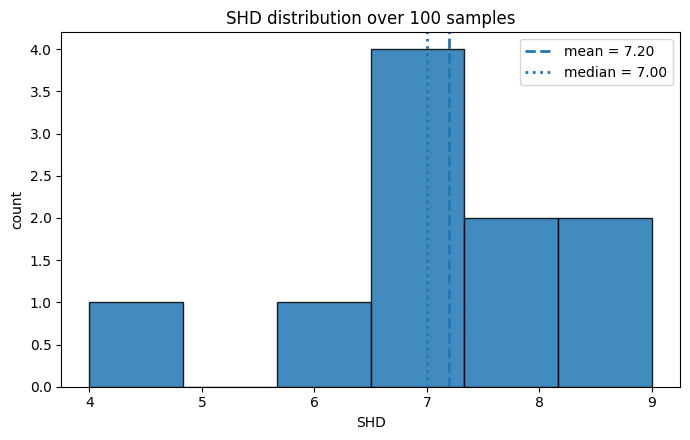

In [171]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- config ---
num_runs = 10          # how many times to sample/measure SHD
bins = 'auto'           # or an int, e.g. 20

shd_test = []

with torch.no_grad():
    prev_mode = generator.training
    generator.eval()  # speed & determinism while sampling

    for i in range(num_runs):
        # generate a fresh snapshot of n_eval rows
        samples = sample(
            transformer, data_sampler, batch_size, generator,
            embedding_dim, device, output_info_list, 10000
        )
        # compute SHD vs real
        shd_value = float(shd_against_real(samples, cg_org))
        shd_test.append(shd_value)

    generator.train(prev_mode)

# --- stats ---
shd_arr = np.asarray(shd_test, dtype=float)
mean_val   = float(shd_arr.mean())
median_val = float(np.median(shd_arr))
std_val    = float(shd_arr.std(ddof=1)) if shd_arr.size > 1 else 0.0
p10, p90   = np.percentile(shd_arr, [10, 90])

print(f"SHD over {num_runs} runs:")
print(f"  mean={mean_val:.3f}  median={median_val:.3f}  std={std_val:.3f}")
print(f"  p10={p10:.3f}  p90={p90:.3f}")

# --- histogram ---
plt.figure(figsize=(7, 4.5))
counts, edges, _ = plt.hist(shd_arr, bins=bins, edgecolor='black', alpha=0.85)
plt.axvline(mean_val,   linestyle='--', linewidth=2, label=f"mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle=':',  linewidth=2, label=f"median = {median_val:.2f}")
plt.title("SHD distribution over 100 samples")
plt.xlabel("SHD")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


In [161]:
shd_ground_truth

8.0

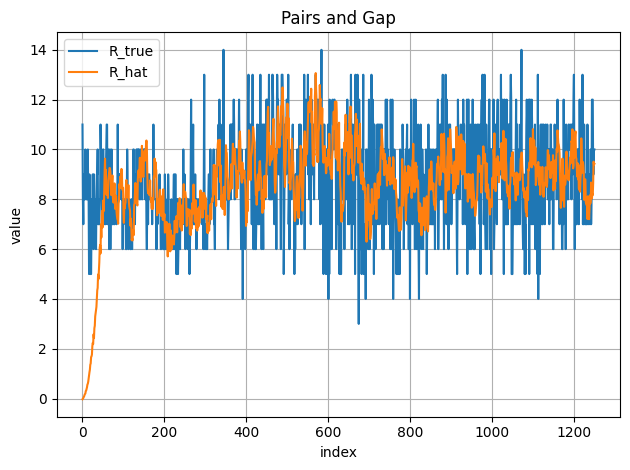

In [162]:
import matplotlib.pyplot as plt
# Convert to arrays
a = np.array([p[0] for p in r_check], dtype=float)   # first value in each tuple
#b = np.array([p[1] for p in r_check], dtype=float)   # second value in each tuple
with torch.no_grad():
#        a = np.array([u.detach().float().cpu().view(-1)[0].item() for (u, v) in r_check], dtype=np.float64)
        b = np.array([v.detach().float().cpu().view(-1)[0].item() for (u, v) in r_check], dtype=np.float64)

# Gap line (absolute difference)
gap = np.abs(b - a)   # use (b - a) if you want signed difference instead

# Plot 3 lines in one figure
x = np.arange(len(r_check))
plt.figure()
plt.plot(x, a, label="R_true")
plt.plot(x, b, label="R_hat")
#plt.plot(x, gap, label="gap = |second - first|")
plt.title("Pairs and Gap")
plt.xlabel("index")
plt.ylabel("value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [163]:
import numpy as np

a = np.asarray(a, dtype=float)
b = np.asarray(b, dtype=float)
mse = np.mean((abs(a) - abs(b)) ** 2)
mse
# np.float64(5.044407577084732)

np.float64(4.947003948733925)

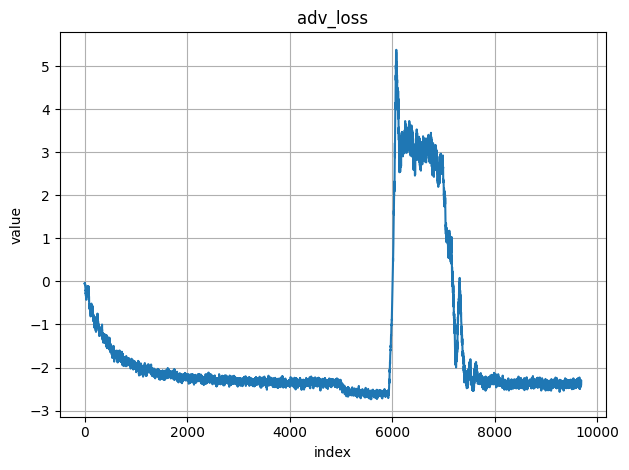

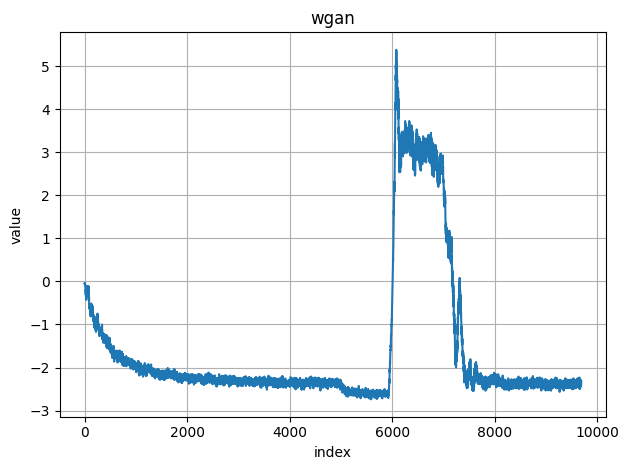

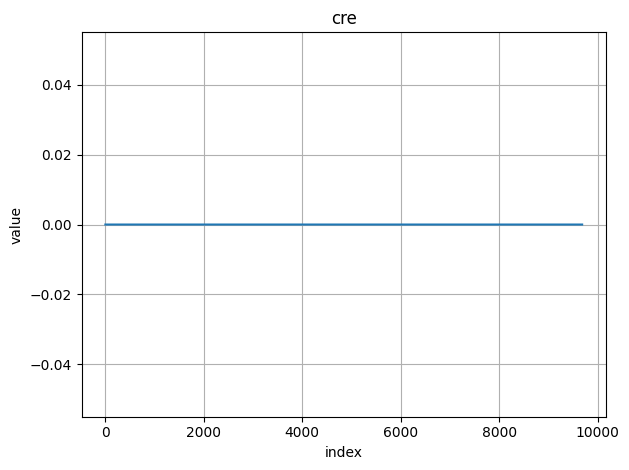

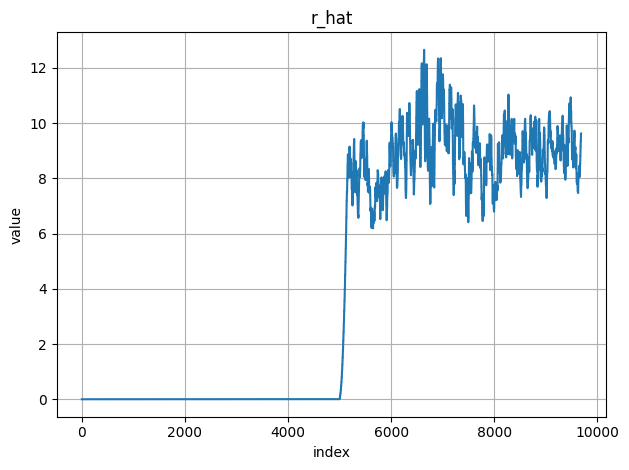

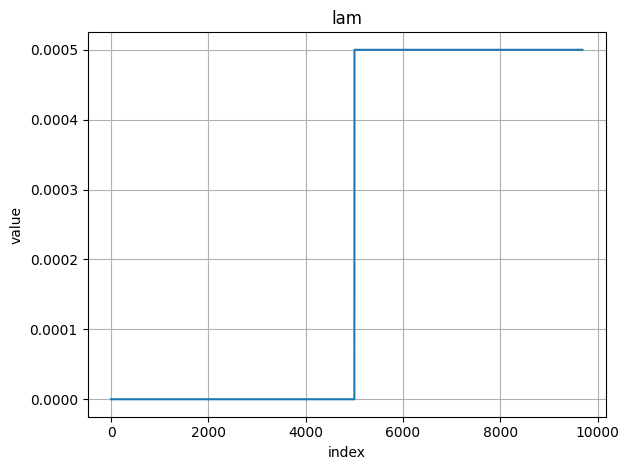

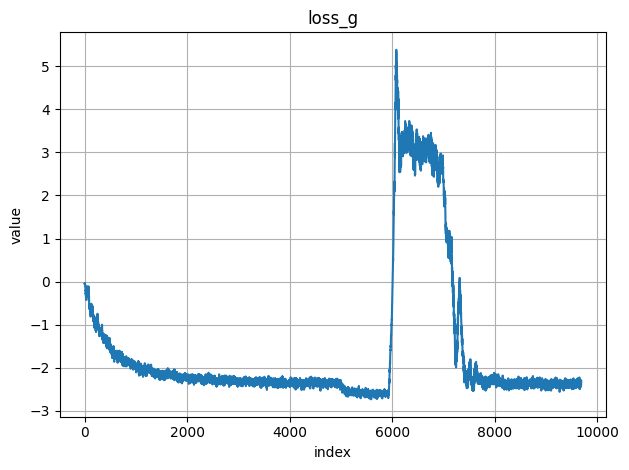

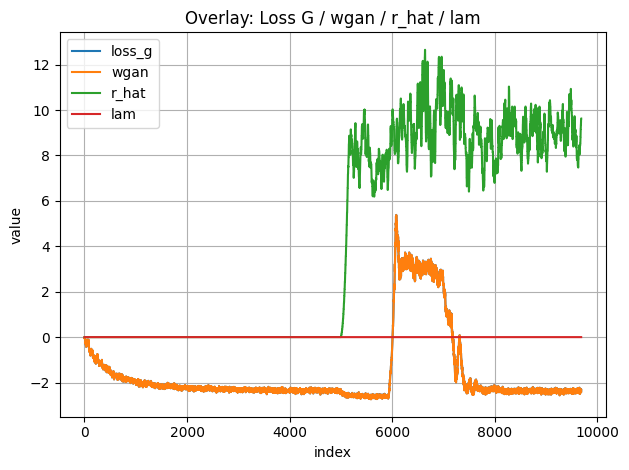

In [164]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def _to_float(x):
    """Safely convert tensor/number to float (handles grad/device/shape)."""
    if isinstance(x, torch.Tensor):
        with torch.no_grad():
            return float(x.detach().cpu().reshape(-1)[0].item())
    return float(x)

def plot_training_metrics(data, save_prefix=None):
    """
    data: iterable of 6-tuples -> (adv_loss, wgan, cre, r_hat, lam, loss_g)
          elements can be tensors (with grad_fn) or numbers.
    Produces:
      - 6 figures: one per metric
      - 1 figure: overlay of adv_loss, wgan, cre, r_hat
    """
    names = ["adv_loss", "wgan", "cre", "r_hat", "lam", "loss_g"]
    cols  = list(zip(*data))  # 6 lists (one per position)
    series = [np.array([_to_float(v) for v in col], dtype=float) for col in cols]
    x = np.arange(len(series[0]))

    # 6 separate charts
    for name, arr in zip(names, series):
        plt.figure()
        plt.plot(x, arr)
        plt.title(name)
        plt.xlabel("index")
        plt.ylabel("value")
        plt.grid(True)
        plt.tight_layout()
        if save_prefix:
            plt.savefig(f"{save_prefix}_{name}.png", dpi=144)

    # Overlay chart: adv_loss, wgan, cre, r_hat
    overlay_idx = [5, 1, 3, 4]
    plt.figure()
    for idx in overlay_idx:
        plt.plot(x, series[idx], label=names[idx])
    plt.title("Overlay: Loss G / wgan / r_hat / lam")
    plt.xlabel("index")
    plt.ylabel("value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_overlay_adv_wgan_rhat_lam.png", dpi=144)

    plt.show()

# ---- Example usage with your real item ----
# Build a tiny list; append more items in practice.
example_data = [
    (
        torch.tensor(-0.0157, requires_grad=True),  # adv_loss
        torch.tensor(-0.0157, requires_grad=True),  # wgan
        0.0,                                        # cre
        torch.tensor(0.4925, requires_grad=True),   # r_hat
        -3.3444816053511705e-06,                    # lam
        -0.015711341053247452                       # loss_g (already a float)
    ),
    # ... add more 6-tuples here ...
]

# plot_training_metrics(example_data, save_prefix="metrics")  # optional saving
plot_training_metrics(lossG)  # just display

In [165]:
# lossG.append((adv_loss, wgan, cre, r_hat, lam, loss_g.item()))

In [166]:
lossG[-1]

(tensor(-2.3916, grad_fn=<AddBackward0>),
 tensor(-2.3916, grad_fn=<NegBackward0>),
 tensor(0.),
 tensor(9.6285),
 0.0005,
 -2.3867976665496826)

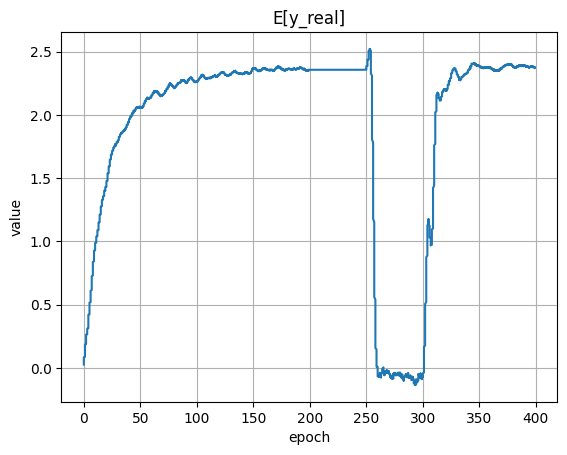

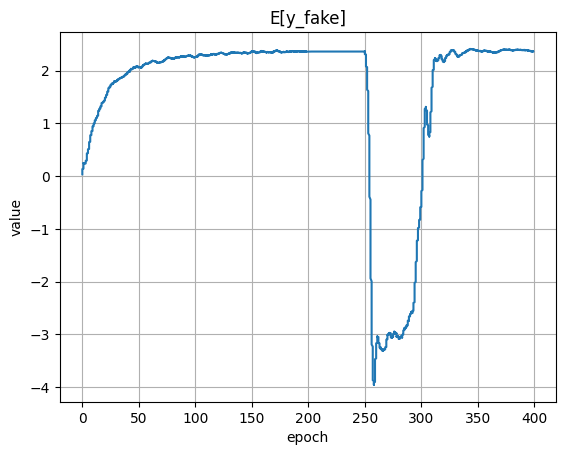

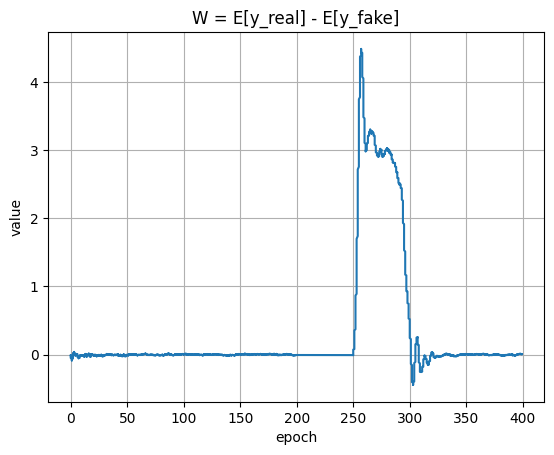

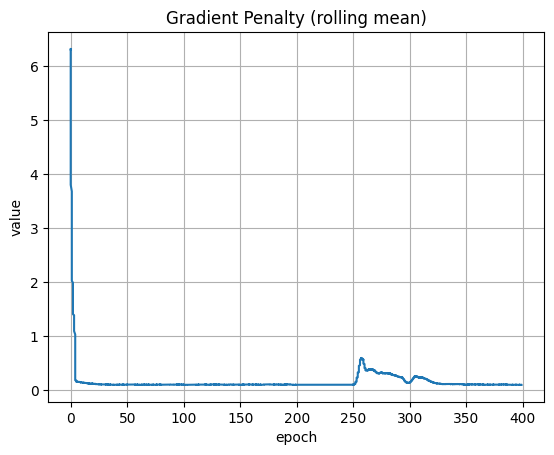

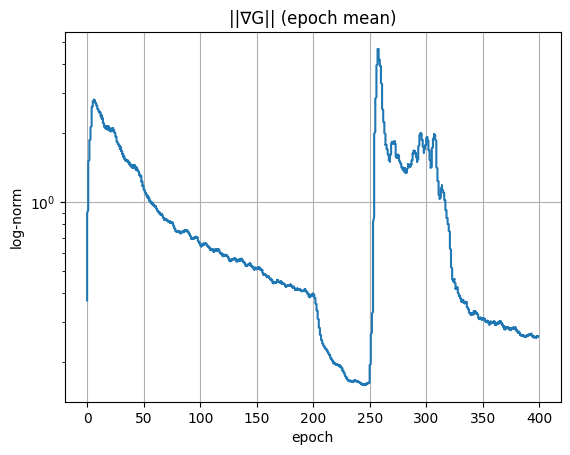

/var/folders/kb/6bc0nggx0y3_h7vrb689sn5w0000gn/T/ipykernel_4969/3853829975.py:31: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


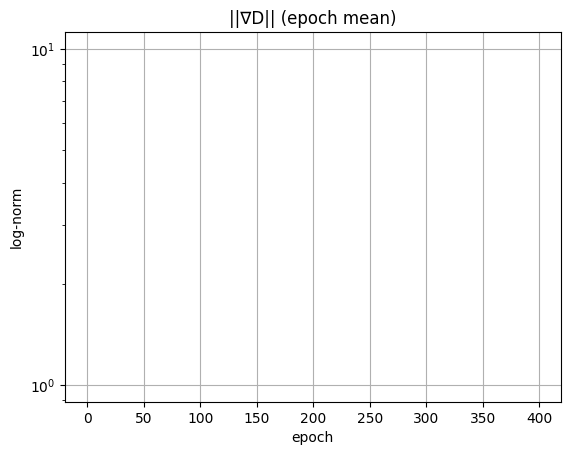

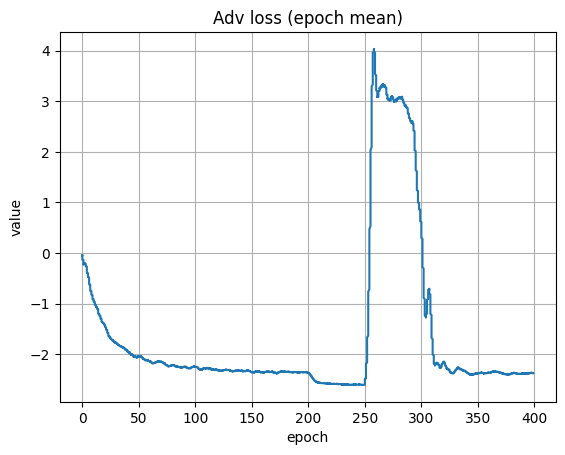

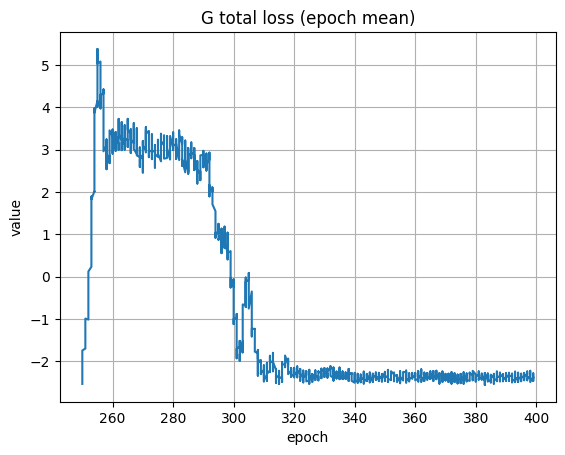

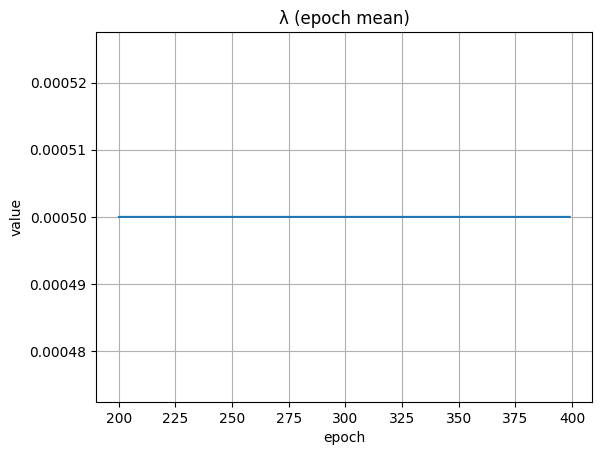

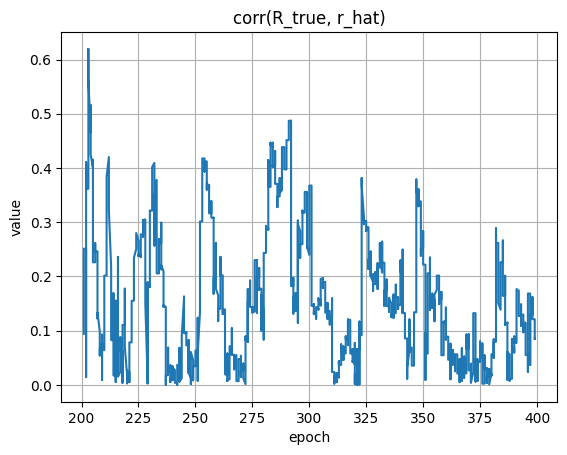

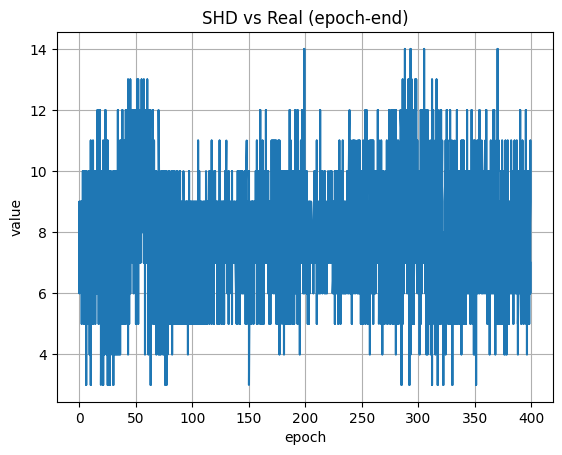

In [167]:
import matplotlib.pyplot as plt

def plot_series(xs, ys, title, xlabel="epoch", ylabel="value"):
    plt.figure()
    plt.plot(xs, ys)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

epochs = hist_epoch

# 1) y_real & y_fake & W
plot_series(epochs, yreal_epoch_mean, "E[y_real]")
plot_series(epochs, yfake_epoch_mean, "E[y_fake]")
if len(yreal_epoch_mean) == len(yfake_epoch_mean):
    w_series = (np.array(yreal_epoch_mean) - np.array(yfake_epoch_mean)).tolist()
    plot_series(epochs, w_series, "W = E[y_real] - E[y_fake]")

# 2) D-loss & GP (dloss_epoch bạn có sẵn; ở đây dùng gp_epoch_mean)
plot_series(epochs, gp_epoch_mean, "Gradient Penalty (rolling mean)")

# 3) Grad norms (log-scale)
plt.figure()
plt.plot(epochs, gnorm_epoch_mean)
plt.yscale('log')
plt.title("||∇G|| (epoch mean)"); plt.xlabel("epoch"); plt.ylabel("log-norm")
plt.grid(True); plt.show()

plt.figure()
plt.plot(epochs, dnorm_epoch_mean)
plt.yscale('log')
plt.title("||∇D|| (epoch mean)"); plt.xlabel("epoch"); plt.ylabel("log-norm")
plt.grid(True); plt.show()

# 4) Update norms
#plot_series(epochs, glr_epoch_mean, "||Δθ_G|| (epoch mean)")
#plot_series(epochs, dlr_epoch_mean, "||Δθ_D|| (epoch mean)")

# 5) Adv & G total
plot_series(epochs, adv_epoch_mean, "Adv loss (epoch mean)")
plot_series(epochs, gtot_epoch, "G total loss (epoch mean)")

# 6) Lambda shaping
plot_series(epochs, lam_epoch_mean, "λ (epoch mean)")

# 7) Critic corr
plot_series(epochs, corr_epoch, "corr(R_true, r_hat)")

# 8) SHD
plot_series(epochs, shd_epoch, "SHD vs Real (epoch-end)")

# 9) VarRatio@k
for k, series in varratio_epoch_by_col.items():
    plot_series(epochs, series, f"VarRatio@{k} (fake/real)")

In [168]:
abc

NameError: name 'abc' is not defined

In [ ]:
for i in epoch_iterator:
        # stage switch
        if i < pretrain_gd_epochs:
            stage = "gd"    # D/G only
        elif i < t0:
            stage = "r"     # Critic only
        else:
            stage = "all"   # shaping (gated + annealed + capped)

        for _ in range(steps_per_epoch):
            # --------- D steps (skip in stage 'r') ---------
            if stage != "r":
                for _d in range(discriminator_steps):
                    fakez = torch.normal(mean=mean, std=std)
                    condvec =  data_sampler.sample_condvec( batch_size)
                    if condvec is None:
                        c1, m1, col, opt = None, None, None, None
                        real =  data_sampler.sample_data(train_data,  batch_size, col, opt)
                    else:
                        c1, m1, col, opt = condvec
                        c1 = torch.from_numpy(c1).to( device)
                        m1 = torch.from_numpy(m1).to( device)
                        fakez = torch.cat([fakez, c1], dim=1)

                        perm = np.arange( batch_size)
                        np.random.shuffle(perm)
                        real =  data_sampler.sample_data(
                            train_data,  batch_size, col[perm], opt[perm]
                        )
                        c2 = c1[perm]

                    fake =  generator(fakez)
                    fakeact =  apply_activate(output_info_list, fake)

                    real = torch.from_numpy(real.astype('float32')).to( device)

                    if c1 is not None:
                        fake_cat = torch.cat([fakeact, c1], dim=1)
                        real_cat = torch.cat([real, c2], dim=1)
                    else:
                        fake_cat = fakeact
                        real_cat = real

                    y_fake = discriminator(fake_cat)
                    y_real = discriminator(real_cat)

                    pen = discriminator.calc_gradient_penalty(
                        real_cat, fake_cat,  device, pac
                    )
                    loss_d = -(torch.mean(y_real) - torch.mean(y_fake))
                    loss_d_total = loss_d + pen
                        
                    # --- MONITOR: D-step (trước optimizerD.step) ---
                    with torch.no_grad():
                        buf_yreal.append(y_real.mean().item())
                        buf_yfake.append(y_fake.mean().item())
                        # pen có thể là tensor/float
                        pen_val = pen.item() if hasattr(pen, 'item') else float(pen)
                        buf_gp.append(pen_val)

                    optimizerD.zero_grad(set_to_none=False)
                    # Sau optimizerD.step():
                    with torch.no_grad():
                        buf_dnorm.append(grad_norm(discriminator))
                        buf_dlr.append(param_update_norm(optimizerD))
                    loss_d_total.backward()
                    optimizerD.step()

            # --------- G forward (to build critic_input) ---------
            fakez = torch.normal(mean=mean, std=std)
            condvec =  data_sampler.sample_condvec( batch_size)
            if condvec is None:
                c1, m1, col, opt = None, None, None, None
            else:
                c1, m1, col, opt = condvec
                c1 = torch.from_numpy(c1).to( device)
                m1 = torch.from_numpy(m1).to( device)
                fakez = torch.cat([fakez, c1], dim=1)

            fake =  generator(fakez)
            fakeact =  apply_activate(output_info_list, fake)

            if c1 is not None:
                y_fake = discriminator(torch.cat([fakeact, c1], dim=1))
                cross_entropy =  cond_loss(fake, c1, m1)
                #critic_input = torch.cat([fakeact, c1], dim=1)
                critic_input = fakeact
            else:
                y_fake = discriminator(fakeact)
                cross_entropy = 0
                critic_input = fakeact

            adv_loss = -torch.mean(y_fake) + cross_entropy  # WGAN-GP + cond
            wgan = -torch.mean(y_fake)
            cre = cross_entropy  
            with torch.no_grad():
                buf_adv.append(float(adv_loss.item()))

            # --------- R step (train Critic thưa) ---------
            if stage != "gd" and (global_step % k_step_R) == 0:
                with torch.no_grad():
                    shds = []
                    for _k in range(5):  # average of 5 snapshots
                        if i < 50:
                            n_eval = max(1000, len(train_data)// 5)
                        else:
                            n_eval = max(1000, len(train_data)// 2)
                            
                        prev =  generator.training
                        generator.eval()
                        gen_df = sample(transformer, data_sampler, batch_size, generator, embedding_dim, device, output_info_list, n_eval)
                        generator.train(prev)
                        shds.append(shd_against_real(gen_df, cg_org))
                    shd_val = float(np.median(shds))
                    shd_hist.append(shd_val)
                    
                    # === 2) EMA trên SHD qua thời gian (làm mượt giữa các step/epoch) ===
                    beta_shd = 0.7  # hệ số EMA cho SHD
                    shd_val = beta_shd * shd_ema + (1.0 - beta_shd) * shd_val
                    shd_ema = shd_val
                    # New
                    ctrl['shd_prev'] = float(shd_ema) if math.isfinite(shd_ema) else ctrl['shd_prev']

                    
                    R_true_scalar = float(shd_ema)

                R_true = torch.tensor(R_true_scalar, dtype=torch.float32, device= device)

                optimizerR.zero_grad(set_to_none=False)
                feat_batch = batch_features(critic_input.detach())        # (2D',)
                logit = reward_critic(feat_batch.unsqueeze(0)).squeeze(0)  # scalar
                lossR = mse(logit, R_true)
                last_lossR = float(lossR.detach().cpu())
                lossR.backward()
                torch.nn.utils.clip_grad_norm_(reward_critic.parameters(), 5.0)
                optimizerR.step()
                r_check.append((R_true_scalar, logit))  # cùng thang [0,1]

                # thu thập tương quan r_hat ~ R_true để gating chất lượng Critic
                with torch.no_grad():
                    r_hat_now = float(torch.sigmoid(logit).detach().cpu())
                    corr_buf.append((R_true_scalar, r_hat_now))

                if stage == "r":
                    global_step += 1
                    continue  # pretrain-R: skip G update

            # --------- G step (shaping with gate + anneal + cap + auto-off) ---------
            # freeze critic params while using it
            for p in reward_critic.parameters(): p.requires_grad_(False)
            reward_critic.eval()

            feat_g = batch_features(critic_input)   # keeps grad to critic_input -> G
            r_hat = reward_critic(feat_g.unsqueeze(0)).squeeze(0)  # scalar
            # --- TÍNH LAM: tăng theo epoch, nhưng có thể đảo dấu dựa vào lịch sử r̂ ---
            base_lam = lambda_max * min(1.0, i / epochs)

            # Dùng sigmoid(r_hat) để so sánh trên thang [0,1]
            r_hat_sig = torch.sigmoid(r_hat).detach().cpu().item()

            if len(rhat_hist) > 0:
                mean_prev = sum(rhat_hist) / len(rhat_hist)
                # nếu r̂ hiện tại nhỏ hơn mean của 10 r̂ trước (trừ biên flip_tol) -> đảo dấu
                sign = -1.0 if (r_hat_sig < (mean_prev - flip_tol)) else 1.0
            else:
                # chưa đủ lịch sử -> giữ dương
                sign = 1.0

            lam = base_lam * sign

            # Cập nhật lịch sử SAU khi quyết định sign để không làm lệch mean
            rhat_hist.append(r_hat_sig)

            #lam = lambda_max * (min(1.0, (i)/epochs))

            # Nếu có lam (ở stage 'all'):
            if 'lam' in locals():
                buf_lam.append(lam)

            loss_g = adv_loss - lam * r_hat
            # adv_loss = -torch.mean(y_fake) + cross_entropy
            lossG.append((adv_loss, wgan, cre, r_hat, lam, loss_g.item()))

            optimizerG.zero_grad(set_to_none=False)
            loss_g.backward()
            torch.nn.utils.clip_grad_norm_( generator.parameters(), 5.0)
            optimizerG.step()
            # Sau optimizerG.step():
            with torch.no_grad():
                buf_gnorm.append(grad_norm(generator))
                buf_glr.append(param_update_norm(optimizerG))

            reward_critic.train()
            for p in reward_critic.parameters(): p.requires_grad_(True)

            global_step += 1

In [ ]:
import pickle

def convert_tetrad_graph(graph_path, save_path):
    with open(graph_path, 'r') as f:
        node_flag = False
        for line in f:
            if node_flag:
                vars = line.strip().split(';')
                vals = [[] for _ in range(len(vars))]
                graph_dict = dict(zip(vars, vals))
                node_flag = False
            if line.strip() == 'Graph Nodes:':
                node_flag = True

            line_content = line.strip()
            if ' --> ' in line_content:
                dot_idx = line_content.index('.')
                line_content = line_content[dot_idx + 2:]
                cause_effct = line_content.split(' --> ')
                graph_dict[cause_effct[1]].append(cause_effct[0])

    graph_output = [[k, v] for k, v in graph_dict.items()]
    with open(save_path, 'wb') as f:
        pickle.dump(graph_output, f)

In [ ]:
graph_path = "/Users/josephnguyen/CTGAN/ctgan/original_graph.txt"
save_path = '/Users/josephnguyen/CTGAN/ctgan/graph.txt'
convert_tetrad_graph(graph_path, save_path)

## Check Critic Only

In [ ]:
import numpy as np
import torch
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error

mse = MSELoss()
bce = BCEWithLogitsLoss()

# giả sử bạn đã có: generator, reward_critic, optimizerR, transformer, data_sampler, cg_org

def evaluate_critic(n_eval=2000, n_snap=5, beta=0.9):
    """Sinh data giả, tính SHD → reward thật (R_true), so với r_hat từ Critic."""
    shds = []
    with torch.no_grad():
        prev = generator.training
        generator.eval()
        for _ in range(n_snap):
            gen_df = sample(
                transformer, data_sampler, batch_size,
                generator, embedding_dim, device, output_info_list, n_eval
            )
            shds.append(shd_against_real(gen_df, cg_org))
        generator.train(prev)
    shd_val = np.median(shds)  # median snapshot
    # EMA smoothing (optional)
    global shd_ema
    shd_ema = beta*shd_ema + (1-beta)*shd_val if "shd_ema" in globals() else shd_val

    alpha_dyn = 0.2 if shd_ema > 8 else 0.02
    R_true_scalar = float(np.exp(-alpha_dyn * shd_ema))

    return R_true_scalar

def train_critic_step(critic_input, R_true_scalar):
    """1 bước update Critic"""
    R_true = torch.tensor(R_true_scalar, dtype=torch.float32, device=device)
    optimizerR.zero_grad(set_to_none=False)
    feat_batch = batch_features(critic_input.detach())
    logit = reward_critic(feat_batch.unsqueeze(0)).squeeze(0)
    lossR = bce(logit, R_true)
    lossR.backward()
    torch.nn.utils.clip_grad_norm_(reward_critic.parameters(), 5.0)
    optimizerR.step()
    with torch.no_grad():
        r_hat = torch.sigmoid(logit).cpu().item()
    return float(lossR.item()), r_hat

# === Loop mini để chỉ theo dõi Critic ===
R_true_hist, rhat_hist, loss_hist = [], [], []
for step in range(100):  # vd 100 step Critic only
    # build critic_input như code gốc
    fakez = torch.normal(mean=mean, std=std)
    condvec = data_sampler.sample_condvec(batch_size)
    if condvec is not None:
        c1, m1, col, opt = condvec
        c1 = torch.from_numpy(c1).to(device)
        fakez = torch.cat([fakez, c1], dim=1)
    fake = generator(fakez)
    fakeact = apply_activate(output_info_list, fake)
    critic_input = torch.cat([fakeact, c1], dim=1) if condvec is not None else fakeact

    R_true_scalar = evaluate_critic()
    lossR, r_hat = train_critic_step(critic_input, R_true_scalar)

    R_true_hist.append(R_true_scalar)
    rhat_hist.append(r_hat)
    loss_hist.append(lossR)

# === Evaluate alignment ===
corr = np.corrcoef(R_true_hist, rhat_hist)[0,1]
spearman = spearmanr(R_true_hist, rhat_hist)[0]
mae = mean_absolute_error(R_true_hist, rhat_hist)
mse = mean_squared_error(R_true_hist, rhat_hist)

print(f"Critic corr={corr:.3f} | Spearman={spearman:.3f} | MAE={mae:.4f} | MSE={mse:.4f}")


In [ ]:
# BCE: Critic corr=0.675 | Spearman=0.801 | MAE=0.0052 | MSE=0.0001
# MSE: Critic corr=0.577 | Spearman=0.522 | MAE=0.3179 | MSE=0.1115

In [ ]:
samples = sample(transformer, data_sampler, batch_size, generator, embedding_dim, device, output_info_list, n_eval)
shd_against_real(samples, cg_org)

In [ ]:
shd_test = []
for i in range(10):
    samples = sample(transformer, data_sampler, batch_size, generator, embedding_dim, device, output_info_list, n_eval)
    shd_value = shd_against_real(samples, cg_org)
    shd_test.append(shd_value)
print(f"SHD test values: {shd_test}")
print(f"Average SHD test value: {np.mean(shd_test):.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_series(xs, ys, title, xlabel="epoch", ylabel="value"):
    plt.figure()
    plt.plot(xs, ys)
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

epochs = hist_epoch

# 1) y_real & y_fake & W
plot_series(epochs, yreal_epoch_mean, "E[y_real]")
plot_series(epochs, yfake_epoch_mean, "E[y_fake]")
if len(yreal_epoch_mean) == len(yfake_epoch_mean):
    w_series = (np.array(yreal_epoch_mean) - np.array(yfake_epoch_mean)).tolist()
    plot_series(epochs, w_series, "W = E[y_real] - E[y_fake]")

# 2) D-loss & GP (dloss_epoch bạn có sẵn; ở đây dùng gp_epoch_mean)
plot_series(epochs, gp_epoch_mean, "Gradient Penalty (rolling mean)")

# 3) Grad norms (log-scale)
plt.figure()
plt.plot(epochs, gnorm_epoch_mean)
plt.yscale('log')
plt.title("||∇G|| (epoch mean)"); plt.xlabel("epoch"); plt.ylabel("log-norm")
plt.grid(True); plt.show()

plt.figure()
plt.plot(epochs, dnorm_epoch_mean)
plt.yscale('log')
plt.title("||∇D|| (epoch mean)"); plt.xlabel("epoch"); plt.ylabel("log-norm")
plt.grid(True); plt.show()

# 4) Update norms
plot_series(epochs, glr_epoch_mean, "||Δθ_G|| (epoch mean)")
plot_series(epochs, dlr_epoch_mean, "||Δθ_D|| (epoch mean)")

# 5) Adv & G total
plot_series(epochs, adv_epoch_mean, "Adv loss (epoch mean)")
plot_series(epochs, gtot_epoch, "G total loss (epoch mean)")

# 6) Lambda shaping
plot_series(epochs, lam_epoch_mean, "λ (epoch mean)")

# 7) Critic corr
plot_series(epochs, corr_epoch, "corr(R_true, r_hat)")

# 8) SHD
plot_series(epochs, shd_epoch, "SHD vs Real (epoch-end)")

# 9) VarRatio@k
for k, series in varratio_epoch_by_col.items():
    plot_series(epochs, series, f"VarRatio@{k} (fake/real)")